In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import math
import cv2
import random
import copy

import torchvision.transforms.functional as F
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision.utils import _log_api_usage_once
print(torch.__version__)
dir = '/Documents/Pytorch_stuff/CNN_intro/Facial_Detection'

import os
#for dirname, _, filenames in os.walk('/Documents/Pytorch_stuff/CNN_intro/Facial_Detection/facial_keypoints'):
for dirname, _, filenames in os.walk('./facial_keypoints', topdown=False):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings('ignore')

1.13.1+cu116
./facial_keypoints\IdLookupTable.csv
./facial_keypoints\SampleSubmission.csv
./facial_keypoints\test.zip
./facial_keypoints\training.zip


In [2]:
print("Pytorch CUDA Version is ", torch.version.cuda)
print("Whether CUDA is supported by our system:", torch.cuda.is_available())

print(torch.backends.cudnn.enabled)
print(torch.zeros(1).cuda())

Pytorch CUDA Version is  11.6
Whether CUDA is supported by our system: True
True
tensor([0.], device='cuda:0')


In [3]:
torch.manual_seed(2)
np.random.seed(3)
random.seed(4)

In [4]:
# !unzip ../input/facial-keypoints-detection/training.zip
# !unzip ../input/facial-keypoints-detection/test.zip

import zipfile
#if not os.path.exists(dir+'/facial_keypoints/training.csv'):
if not os.path.exists('./facial_keypoints/training.csv'):
    with zipfile.ZipFile('./facial_keypoints/training.zip', 'r') as zip_ref:
        zip_ref.extractall('./working')
if not os.path.exists('./facial_keypoints/test.csv'):
    with zipfile.ZipFile('./facial_keypoints/test.zip', 'r') as zip_ref:
        zip_ref.extractall('./working')

In [5]:
train_data = pd.read_csv('./working/training.csv')
test_data = pd.read_csv('./working/test.csv')
id_lookup_data = pd.read_csv('./facial_keypoints/IdLookupTable.csv')

In [6]:
print(train_data.shape, test_data.shape)

(7049, 31) (1783, 2)


In [7]:
train_data.head(3)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...


In [8]:
test_data.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [10]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageId  1783 non-null   int64 
 1   Image    1783 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.0+ KB


<AxesSubplot:>

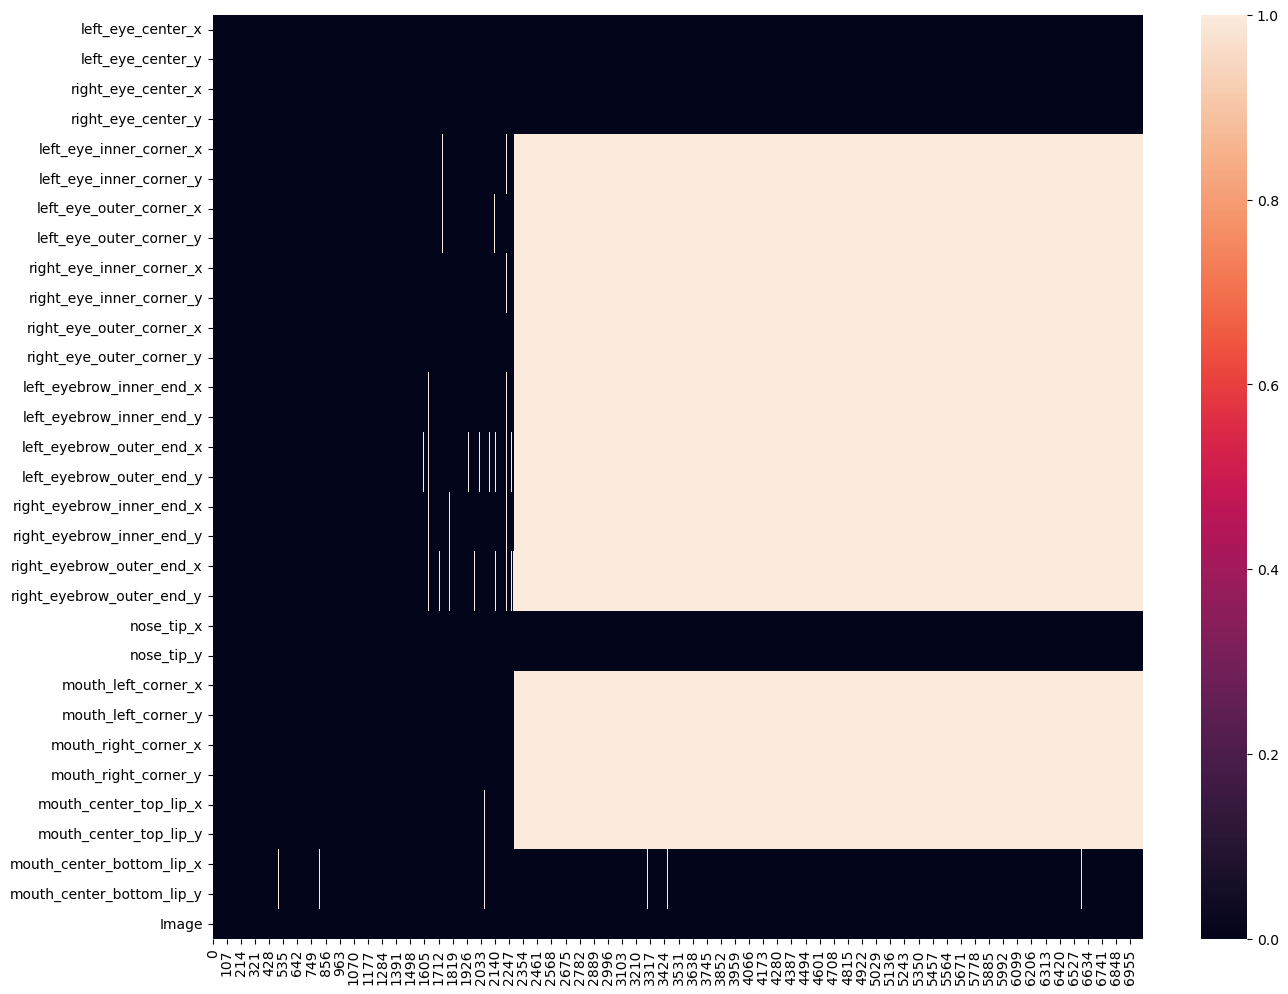

In [11]:
plt.subplots(figsize=(15,12))
sns.heatmap(train_data.isna().T)

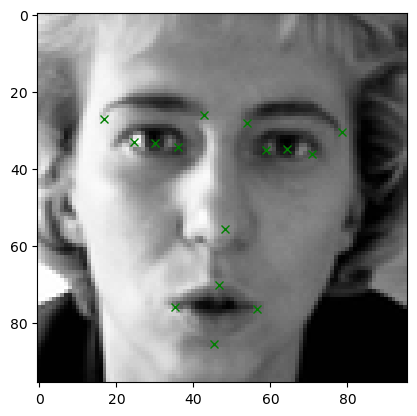

In [12]:
def get_image_and_keypoints(series):
    image = series['Image']
    image = np.fromstring(image, sep=' ').reshape([96, 96]) / 255.0
    keypoints = pd.DataFrame(series).drop(['Image'], axis=0).values.reshape([15, 2])
    return image, keypoints


def get_image_and_keypoints_by_id(train_data, id):
    series = train_data.iloc[id]
    return get_image_and_keypoints(series)


def show_image_with_keypoints(series):
    image, keypoints = get_image_and_keypoints(series)
    plt.imshow(image, cmap='gray')
    plt.plot(keypoints[:, 0], keypoints[:, 1], 'gx')


def show_image_with_keypoints_by_id(train_data, id):
    series = train_data.iloc[id]
    show_image_with_keypoints(series)
    
show_image_with_keypoints_by_id(train_data, 1)

In [13]:
duplicates = train_data.duplicated(subset = 'Image', keep='last')
print(f"There are {sum(duplicates)} duplicates.")
duplicates_list = [g for _, g in train_data.groupby("Image") if len(g) > 1]     

There are 555 duplicates.


In [14]:
duplicates_df = pd.concat(duplicates_list)
duplicates_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098 entries, 3648 to 4846
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          1098 non-null   float64
 1   left_eye_center_y          1098 non-null   float64
 2   right_eye_center_x         1098 non-null   float64
 3   right_eye_center_y         1098 non-null   float64
 4   left_eye_inner_corner_x    2 non-null      float64
 5   left_eye_inner_corner_y    2 non-null      float64
 6   left_eye_outer_corner_x    2 non-null      float64
 7   left_eye_outer_corner_y    2 non-null      float64
 8   right_eye_inner_corner_x   2 non-null      float64
 9   right_eye_inner_corner_y   2 non-null      float64
 10  right_eye_outer_corner_x   1 non-null      float64
 11  right_eye_outer_corner_y   1 non-null      float64
 12  left_eyebrow_inner_end_x   2 non-null      float64
 13  left_eyebrow_inner_end_y   2 non-null      fl

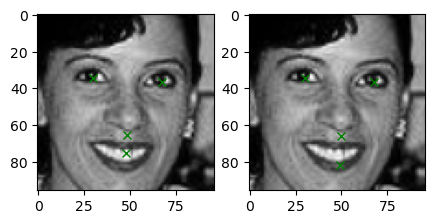

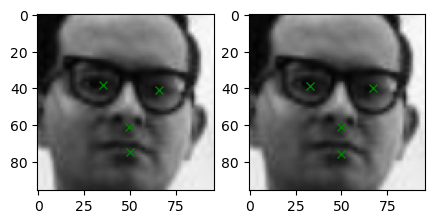

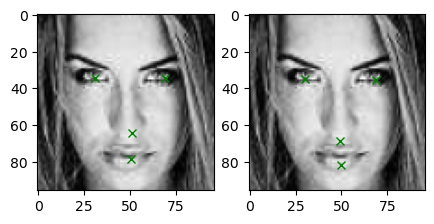

In [15]:
pics_num = 3
for duplicate_df in duplicates_list[:pics_num]:
    n_rows = len(duplicate_df)
    fig = plt.figure(figsize=(5, 5*n_rows))
#     print(n_rows)
    i = 1
    for index, row in duplicate_df.iterrows():        
        image, keypoints = get_image_and_keypoints(row)
        fig.add_subplot(1, n_rows, i)
        plt.imshow(image, cmap='gray')
        plt.plot(keypoints[:,0], keypoints[:,1], 'gx')
        i += 1
    plt.show()

In [16]:
#removing the duplicates
for duplicate_df in duplicates_list:
        n_rows = len(duplicate_df)
        keypoints_list = []
        image = None
        indexes = []
        for index, row in duplicate_df.iterrows():
            image = row['Image']
            indexes.append(index)
            keypoints_df = pd.DataFrame(row).drop(['Image'], axis=0).values
            keypoints_list.append(keypoints_df)

        keypoints_list = np.array(keypoints_list)
        keypoints_list = keypoints_list.reshape((n_rows, 30,))
        # New keypoint as average of all duplicates
        new_keypoints = np.nanmean(keypoints_list, dtype=np.float64, axis=0)
        index_lowest_lip = np.argmax(keypoints_list, axis=0)[-1]
        # Bottom lip from the lowest point in duplicates
        new_keypoints[-1] = keypoints_list[index_lowest_lip, -1]
        new_keypoints[-2] = keypoints_list[index_lowest_lip, -2]
        # Concat keypoints with image
        new_row = new_keypoints.tolist()
        new_row.append(image)
        
        # Delete all duplicates
        train_data.drop(index=indexes, inplace=True)
        # Add new row
        train_data.loc[max(train_data.index) + 1] = new_row

In [17]:
del duplicates, duplicates_df, duplicates_list

In [18]:
train_data.reset_index(drop=True, inplace=True)

In [19]:
#Zero the loss when expected value equals NaN
def NaNMSELoss(output, target):
    filter = ~torch.isnan(target)
    return ((output[filter] - target[filter]) ** 2).mean()

In [20]:
class FacialKeypointsDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, transforms=None):
        self.df = dataframe
        self.transforms = transforms
        
        self.images = []
        self.keypoints = []
        
        for index, row in self.df.iterrows():
            # Image
            image = row['Image']
            image = np.fromstring(image, sep=' ').reshape([96, 96])
            image = np.stack((image, image, image), axis=-1)
            image = image / 255.0
            
            # Keypoints
            keypoints = row.drop(['Image'])
            keypoints = keypoints.to_numpy().astype('float32')
            
            # Add to Dataset's images and keypoints
            self.images.append(image)
            self.keypoints.append(keypoints)

    def __getitem__(self, idx):
        image = self.images[idx]
        keypoints = self.keypoints[idx]
        
        return_dict = {'image': image, 'keypoints': keypoints}

        if self.transforms:
            return_dict = self.transforms(return_dict)

        return return_dict

    def __len__(self):
        return len(self.df)

7049


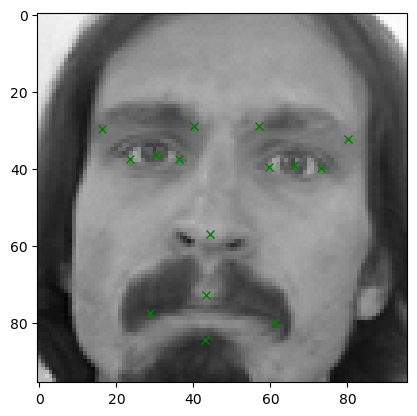

In [21]:
dataset = FacialKeypointsDataset(pd.read_csv('./working/training.csv'))
print(len(dataset))
datapoint = dataset[0]
img = datapoint['image']
keypoints = datapoint['keypoints']
plt.imshow(img, cmap='gray')
plt.plot(keypoints[0::2], keypoints[1::2], 'gx')
plt.show()

In [22]:
#Data augmentation: 
def rotate_point(origin, point, angle):
    xo, yo = origin
    xp, yp = point

    x_final = xo + math.cos(math.radians(angle)) * (xp - xo) - math.sin(math.radians(angle)) * (yp - yo)
    y_final = yo + math.sin(math.radians(angle)) * (xp - xo) + math.cos(math.radians(angle)) * (yp - yo)
    return x_final, y_final


def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result


def translate_image(image, translate):
    y, x = image.shape[0], image.shape[1]

    xp = x * translate[0]
    yp = y * translate[1]

    M = np.float32([[1, 0, xp], [0, 1, yp]])
    shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    return shifted

In [23]:
class MyRandomVerticalFlip(object):
    def __init__(self, p=0.5):
        super().__init__()
        _log_api_usage_once(self)
        if not (isinstance(p, float) and (0.0 <= p <= 1.0)):
            raise ValueError("probability should be float between 0 and 1")
        self.p = p

    def __call__(self, img_with_keypoints):
        if torch.rand(1) < self.p:
            image, keypoints = img_with_keypoints["image"], img_with_keypoints["keypoints"]

            # Image
            # new_image = F.vflip(image)
            new_image = np.fliplr(image)

            # Keypoints
            width_img = image.shape[0]
            old_keypoints = keypoints
            new_keypoints = np.copy(keypoints)
            # left eye center x, y
            new_keypoints[0] = width_img - old_keypoints[2]
            new_keypoints[1] = old_keypoints[3]
            # right eye center x, y
            new_keypoints[2] = width_img - old_keypoints[0]
            new_keypoints[3] = old_keypoints[1]
            # left eye inner corner x, y
            new_keypoints[4] = width_img - old_keypoints[8]
            new_keypoints[5] = old_keypoints[9]
            # left eye outer corner x, y
            new_keypoints[6] = width_img - old_keypoints[10]
            new_keypoints[7] = old_keypoints[11]
            # right eye inner corner x, y
            new_keypoints[8] = width_img - old_keypoints[4]
            new_keypoints[9] = old_keypoints[5]
            # right eye outer corner x, y
            new_keypoints[10] = width_img - old_keypoints[6]
            new_keypoints[11] = old_keypoints[7]
            # left eyebrow inner end x, y
            new_keypoints[12] = width_img - old_keypoints[16]
            new_keypoints[13] = old_keypoints[17]
            # left eyebrow outer end x, y
            new_keypoints[14] = width_img - old_keypoints[18]
            new_keypoints[15] = old_keypoints[19]
            # right eyebrow inner end x, y
            new_keypoints[16] = width_img - old_keypoints[12]
            new_keypoints[17] = old_keypoints[13]
            # right eyebrow outer end x, y
            new_keypoints[18] = width_img - old_keypoints[14]
            new_keypoints[19] = old_keypoints[15]
            # nose tip x, y
            new_keypoints[20] = width_img - old_keypoints[20]
            # new_keypoints[21] = old_keypoints[21]
            # mouth left corner x, y
            new_keypoints[22] = width_img - old_keypoints[24]
            new_keypoints[23] = old_keypoints[25]
            # mouth right corner x, y
            new_keypoints[24] = width_img - old_keypoints[22]
            new_keypoints[25] = old_keypoints[23]
            # mouth center top lip x, y
            new_keypoints[26] = width_img - old_keypoints[26]
            # new_keypoints[27] = old_keypoints[27]
            # mouth center bottom lip x, y
            new_keypoints[28] = width_img - old_keypoints[28]
            # new_keypoints[29] = old_keypoints[29]

            return {'image': new_image, 'keypoints': new_keypoints}

        return img_with_keypoints

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(p={self.p})"

In [24]:
class MyRandomRotation(object):
    def __init__(self, angle: int, p=0.5):
        super().__init__()
        _log_api_usage_once(self)
        if not (isinstance(p, float) and (0.0 <= p <= 1.0)):
            raise ValueError("probability should be float between 0 and 1")
        self.p = p
        self.angle = angle

    def __call__(self, img_with_keypoints):
        if torch.rand(1) < self.p:
            angle = np.random.randint(-self.angle, self.angle)
            # angle = np.random.triangular(-self.angles, 0, self.angles)
            image, keypoints = img_with_keypoints["image"], img_with_keypoints["keypoints"]

            # Image rotation
            # new_image = F.vflip(image)
            new_image = rotate_image(image, -angle)

            # Keypoints rotation
            width, height = image.shape[0], image.shape[1]
            origin = (width / 2, height / 2)
            new_keypoints = np.copy(keypoints)
            for i, point in enumerate(keypoints.reshape(15, 2)):
                new_point = rotate_point(origin, point, angle)
                new_keypoints[i * 2] = new_point[0]
                new_keypoints[i * 2 + 1] = new_point[1]

            return {'image': new_image, 'keypoints': new_keypoints}

        return img_with_keypoints

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(p={self.p})"

In [25]:
class MyRandomTranslation(object):
    def __init__(self, translate: (float, float), p=0.5):
        """
        :type translate: (float, float) x, y translate in percent - from 0 to 1
        """
        super().__init__()
        _log_api_usage_once(self)
        if not (isinstance(p, float) and (0.0 <= p <= 1.0)):
            raise ValueError("probability should be float between 0 and 1")
        if not (len(translate) == 2 and (0.0 <= translate[0] <= 1.0) and (0.0 <= translate[1] <= 1.0)):
            raise ValueError("there should be 2 numbers in translate, both between 0 and 1")
        self.p = p
        self.translate = translate

    def __call__(self, img_with_keypoints):
        if torch.rand(1) < self.p:
            image, keypoints = img_with_keypoints["image"], img_with_keypoints["keypoints"]

            height, width = image.shape[0], image.shape[1]
            x_translate_rate = np.random.uniform(low=-self.translate[0], high=self.translate[0])
            y_translate_rate = np.random.uniform(low=-self.translate[1], high=self.translate[1])
            x_translate_pixel = width * x_translate_rate
            y_translate_pixel = height * y_translate_rate

            # Image rotation
            M = np.float32([[1, 0, x_translate_pixel], [0, 1, y_translate_pixel]])
            shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

            # Keypoints rotation
            new_keypoints = np.copy(keypoints)
            for i in range(len(keypoints) // 2):
                new_keypoints[2 * i] = keypoints[2 * i] + x_translate_pixel
                new_keypoints[2 * i + 1] = keypoints[2 * i + 1] + y_translate_pixel

            return {'image': shifted, 'keypoints': new_keypoints}

        return img_with_keypoints

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(p={self.p})"


In [26]:

class MyRandomBrightnessAdjust(object):
    def __init__(self, brightness: float, p=0.5):
        super().__init__()
        _log_api_usage_once(self)
        if not (isinstance(p, float) and (0.0 <= p <= 1.0)):
            raise ValueError("probability should be float between 0 and 1")
        if not (0.0 <= brightness <= 1.0):
            raise ValueError("brightness should be float between 0 and 1")
        self.p = p
        self.brightness = brightness

    def __call__(self, img_with_keypoints):
        if torch.rand(1) < self.p:
            image, keypoints = img_with_keypoints["image"], img_with_keypoints["keypoints"]
            random_brightness = np.random.uniform(low=-self.brightness, high=self.brightness)

            # Image rotation
            hsv = cv2.cvtColor(image.astype('float32'), cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(hsv)

            lim = 255 - random_brightness
            v[v > lim] = 255
            v[v <= lim] += random_brightness

            final_hsv = cv2.merge((h, s, v))
            img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
            img = np.clip(img, 0.0, 1.0)

            # Keypoints rotation

            return {'image': img, 'keypoints': keypoints}

        return img_with_keypoints

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(p={self.p})"

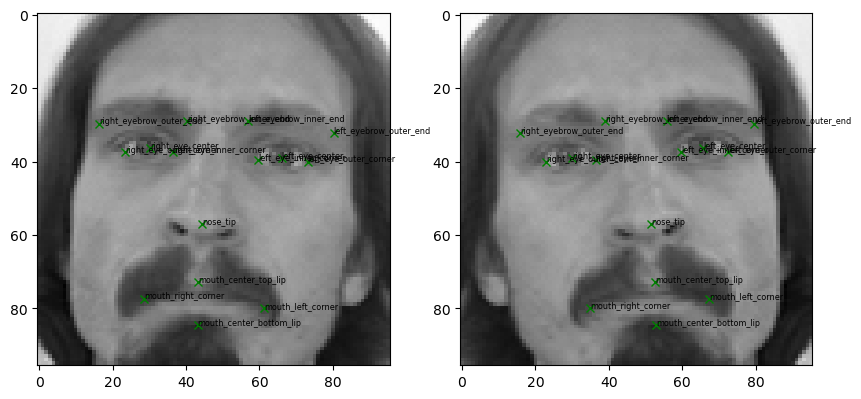

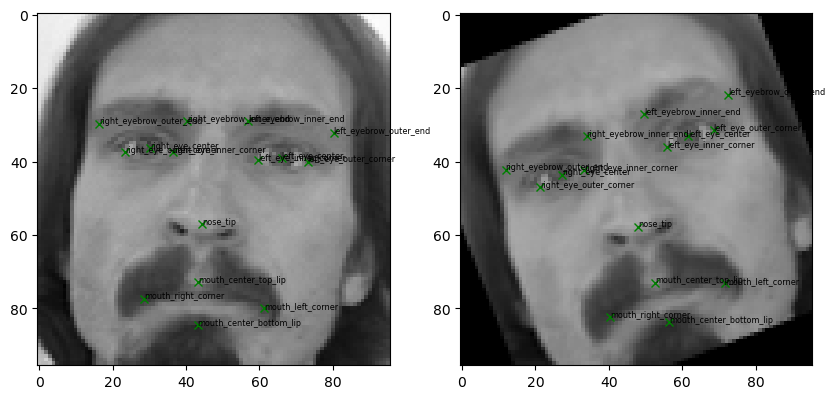

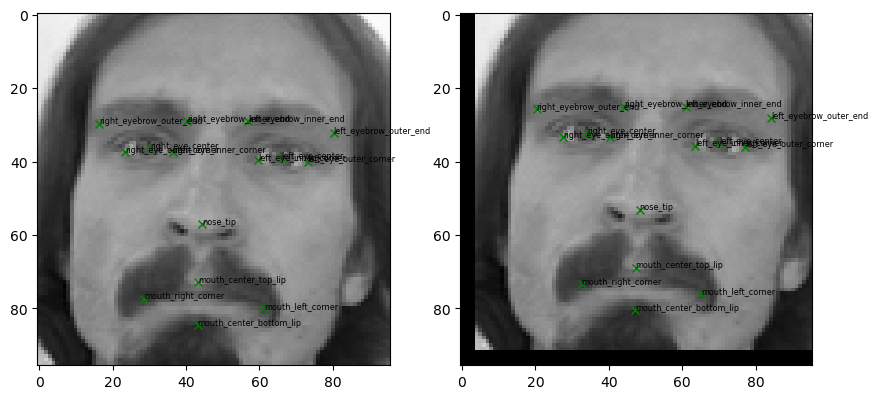

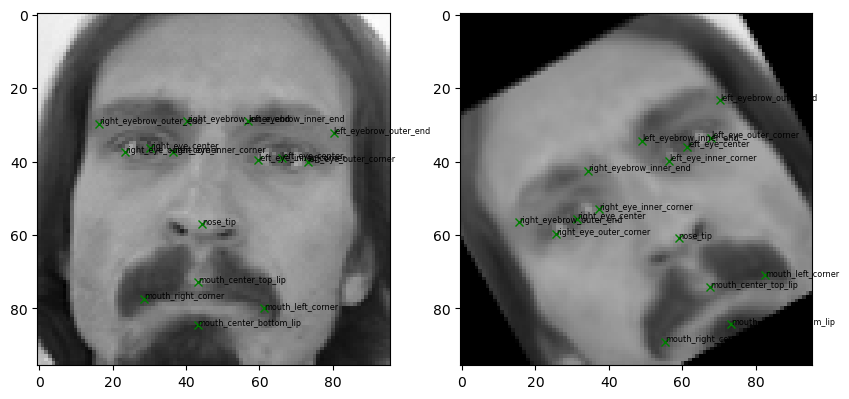

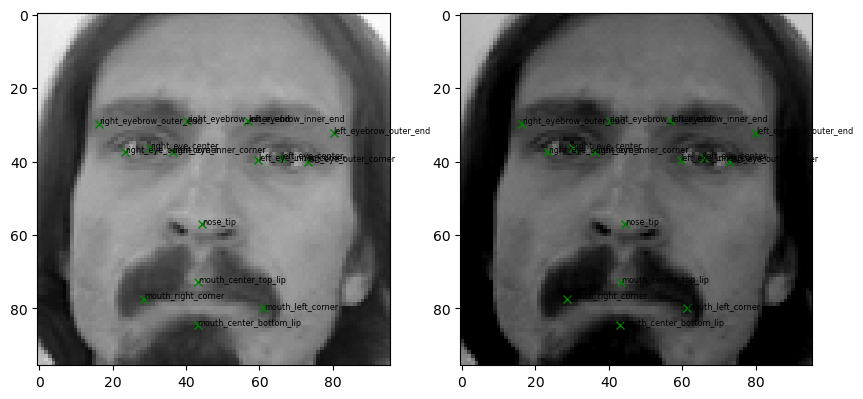

In [27]:
#Test data augmentation
data = pd.read_csv('./working/training.csv')
columns_keypoints = data.columns[:-1]

datapoint = dataset[0]
image, keypoints = datapoint['image'], datapoint['keypoints']

random_flip = MyRandomVerticalFlip(p=1.0)
random_rotation = MyRandomRotation(p=1.0, angle=45)
random_translation = MyRandomTranslation(translate=(0.1, 0.1), p=1.0)
random_brightness = MyRandomBrightnessAdjust(brightness=0.2, p=1.0)

transform_flip = random_flip(datapoint)
transform_rotation = random_rotation(datapoint)
transform_translation = random_translation(datapoint)
transform_combined = random_flip(random_rotation(random_translation(datapoint)))
transform_brightness = random_brightness(datapoint)

transforms_list = [transform_flip, transform_rotation, transform_translation, transform_combined, transform_brightness]

for transformed_image_with_keypoints in transforms_list:
    transformed_image = transformed_image_with_keypoints["image"]
    transformed_keypoints = transformed_image_with_keypoints["keypoints"]
    fig = plt.figure(figsize=(10, 20))
    # Plot original image
    fig.add_subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    for i, keypoint_name in enumerate(columns_keypoints[::2]):
        plt.annotate(keypoint_name[:-2],
                     (keypoints[2 * i], keypoints[2 * i + 1]),
                     fontsize='xx-small')
    plt.plot(keypoints.reshape((15, 2))[:, 0],
             keypoints.reshape((15, 2))[:, 1], 'gx')
    # Plot flipped image
    fig.add_subplot(1, 2, 2)
    plt.imshow(transformed_image, cmap='gray')
    for i, keypoint_name in enumerate(columns_keypoints[::2]):
        plt.annotate(keypoint_name[:-2],
                     (transformed_keypoints[2 * i], transformed_keypoints[2 * i + 1]),
                     fontsize='xx-small')
    plt.plot(transformed_keypoints.reshape((15, 2))[:, 0],
             transformed_keypoints.reshape((15, 2))[:, 1], 'gx')

    plt.show()

In [28]:
class MyToTensor(object):

    def __call__(self, img_with_keypoints):
        image, keypoints = img_with_keypoints["image"], img_with_keypoints["keypoints"]
        image = np.transpose(image, (2, 0, 1)).copy()

        image = torch.from_numpy(image).type(torch.FloatTensor)
        keypoints = torch.from_numpy(keypoints).type(torch.FloatTensor)

        return {'image': image, 'keypoints': keypoints}

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [30]:
BATCH_SIZE = 64
EPOCHS = 40
EPOCHS_PRETRAIN = 25

In [31]:
#import pretrained resnet18
model = torchvision.models.resnet18(pretrained=True)

model.fc = torch.nn.Linear(model.fc.in_features, 30)

model = model.type(torch.FloatTensor)
model = model.to(device)

In [32]:
train_transform = torchvision.transforms.Compose([
     MyRandomVerticalFlip(p=0.5),
     MyRandomRotation(angle=35, p=0.33),
     MyRandomTranslation(translate=(0.12, 0.12), p=0.33),
     MyRandomBrightnessAdjust(brightness=0.2, p=0.5),
     MyToTensor()
    ])

val_transform = torchvision.transforms.Compose([MyToTensor()])

In [33]:
# dataset = FacialKeypointsDataset(pd.read_csv('./training.csv'))

train_size = int(len(dataset) * 0.85)
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

train_set.dataset.transforms = train_transform
val_set.dataset.transforms = val_transform

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=True, batch_size=BATCH_SIZE)

In [34]:
*previous_layers, last_layer = model.parameters()

In [35]:
for layer in previous_layers:
    layer.requires_grad = False

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0.001)

In [37]:
logger = {'train': [], 'val': []}

train_steps = len(train_set) / BATCH_SIZE
val_steps = len(val_set) / BATCH_SIZE

for epoch in range(EPOCHS_PRETRAIN):
    torch.manual_seed(1 + epoch)

    print(f"EPOCH: {epoch + 1}/{EPOCHS_PRETRAIN}")

    model.train()
    train_loss = 0.0
    for (batch_idx, sample) in enumerate(train_loader):
        x = sample['image']
        y = sample['keypoints']
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)
        loss = NaNMSELoss(pred, y)        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss

    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        for val_sample in val_loader:
            x = val_sample['image']
            y = val_sample['keypoints']
            (x, y) = (x.to(device), y.to(device))
            pred = model(x)
            val_loss += NaNMSELoss(pred, y)

    avg_train_loss = train_loss / val_steps
    avg_val_loss = val_loss / val_steps

    logger["train"].append(avg_train_loss.cpu().detach().numpy())
    logger["val"].append(avg_val_loss.cpu().detach().numpy())
    print(f"Average train loss: {avg_train_loss:.6f}, Average validation loss: {avg_val_loss:.6f}")


logger_df = pd.DataFrame(logger)
logger_df.to_csv('logger.csv')

EPOCH: 1/25
Average train loss: 13077.667969, Average validation loss: 1969.579468
EPOCH: 2/25
Average train loss: 9131.363281, Average validation loss: 1365.757202
EPOCH: 3/25
Average train loss: 6294.421387, Average validation loss: 934.907349
EPOCH: 4/25
Average train loss: 4296.432617, Average validation loss: 634.605103
EPOCH: 5/25
Average train loss: 2911.893799, Average validation loss: 427.385773
EPOCH: 6/25
Average train loss: 1959.744141, Average validation loss: 286.511963
EPOCH: 7/25
Average train loss: 1311.981201, Average validation loss: 190.908463
EPOCH: 8/25
Average train loss: 876.251282, Average validation loss: 126.550293
EPOCH: 9/25
Average train loss: 586.868591, Average validation loss: 85.365273
EPOCH: 10/25
Average train loss: 399.121246, Average validation loss: 58.895855
EPOCH: 11/25
Average train loss: 279.227051, Average validation loss: 42.181004
EPOCH: 12/25
Average train loss: 204.075195, Average validation loss: 31.733692
EPOCH: 13/25
Average train loss

In [38]:
for layer in previous_layers:
    layer.requires_grad = True

In [39]:
#Optimizer and Scheduler for training
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.00005)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 25, 40, 65], gamma=0.1)

In [40]:
logger = {'train': [], 'val': []}


best_model = None
min_val_loss = np.inf

train_steps = len(train_set) / BATCH_SIZE
val_steps = len(val_set) / BATCH_SIZE

for epoch in range(EPOCHS):
    torch.manual_seed(1 + epoch)

    print(f"EPOCH: {epoch + 1}/{EPOCHS}")

    model.train()
    train_loss = 0.0
    for (batch_idx, sample) in enumerate(train_loader):
        x = sample['image']
        y = sample['keypoints']
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)
        loss = NaNMSELoss(pred, y)        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss
    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        for val_sample in val_loader:
            x = val_sample['image']
            y = val_sample['keypoints']
            (x, y) = (x.to(device), y.to(device))
            pred = model(x)
            val_loss += NaNMSELoss(pred, y)

    scheduler.step()

    avg_train_loss = train_loss / val_steps
    avg_val_loss = val_loss / val_steps

    logger["train"].append(avg_train_loss.cpu().detach().numpy())
    logger["val"].append(avg_val_loss.cpu().detach().numpy())
    print(f"Average train loss: {avg_train_loss:.6f}, Average validation loss: {avg_val_loss:.6f}")
    
    if min_val_loss > val_loss:
        min_test_loss = val_loss
        best_model = copy.deepcopy(model)


logger_df = pd.DataFrame(logger)
logger_df.to_csv('logger.csv')

EPOCH: 1/40
Average train loss: 42.943661, Average validation loss: 14.877260
EPOCH: 2/40
Average train loss: 24.170340, Average validation loss: 4.439338
EPOCH: 3/40
Average train loss: 17.813744, Average validation loss: 4.930111
EPOCH: 4/40
Average train loss: 15.172340, Average validation loss: 3.953367
EPOCH: 5/40
Average train loss: 12.420356, Average validation loss: 4.305817
EPOCH: 6/40
Average train loss: 9.503022, Average validation loss: 3.492261
EPOCH: 7/40
Average train loss: 8.661494, Average validation loss: 3.590687
EPOCH: 8/40
Average train loss: 7.790523, Average validation loss: 3.302608
EPOCH: 9/40
Average train loss: 7.663341, Average validation loss: 3.400134
EPOCH: 10/40
Average train loss: 7.234276, Average validation loss: 3.490341
EPOCH: 11/40
Average train loss: 6.760168, Average validation loss: 3.610677
EPOCH: 12/40
Average train loss: 6.728106, Average validation loss: 3.531577
EPOCH: 13/40
Average train loss: 6.743929, Average validation loss: 3.489235
EP

In [41]:
best_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

3.3026083


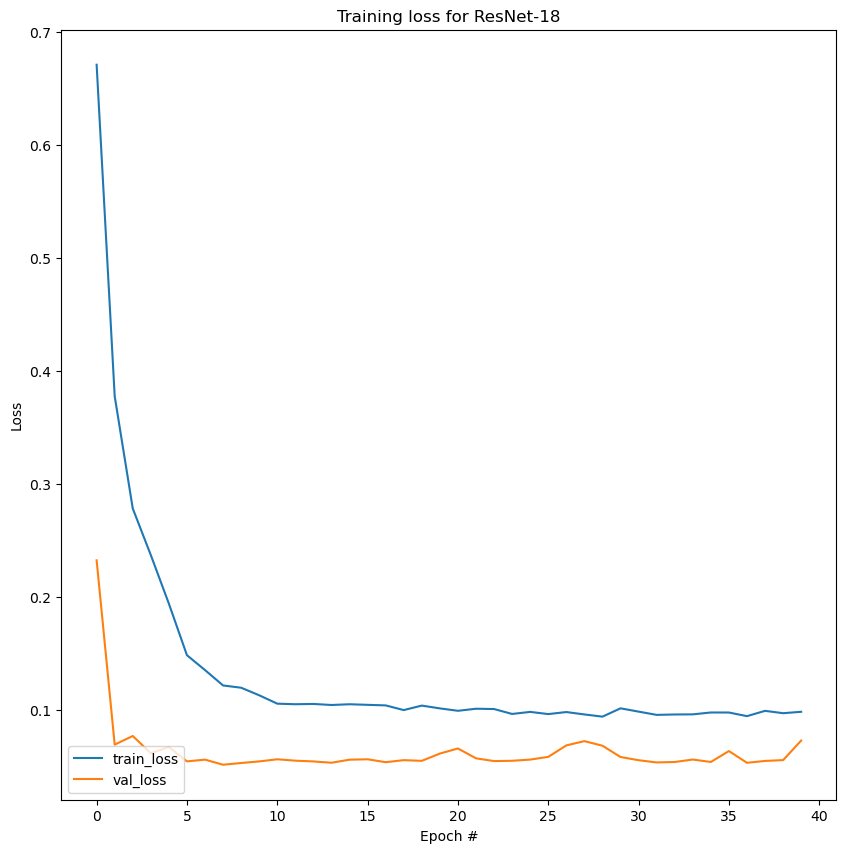

In [42]:
#Training loss
plt.figure(figsize=(10, 10))
plt.plot(logger_df["train"]*train_steps/len(train_set), label="train_loss")
plt.plot(logger_df["val"]*val_steps/len(val_set), label="val_loss")
plt.title("Training loss for ResNet-18")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
print(min(logger_df["val"]))

In [43]:
print(logger_df)

        train        val
0    42.94366   14.87726
1    24.17034   4.439338
2   17.813744  4.9301114
3    15.17234   3.953367
4   12.420356   4.305817
5    9.503022  3.4922614
6    8.661494  3.5906868
7    7.790523  3.3026083
8   7.6633406  3.4001343
9   7.2342763   3.490341
10  6.7601676  3.6106775
11  6.7281055  3.5315769
12  6.7439294  3.4892354
13  6.6854076  3.4151993
14  6.7264376   3.587852
15   6.694049  3.6102078
16  6.6620917  3.4461448
17  6.3967338  3.5608187
18   6.651273  3.5222602
19   6.492767  3.9338121
20  6.3563924   4.223167
21  6.4731035  3.6645877
22   6.456561  3.5083578
23   6.177532  3.5258195
24  6.2940717  3.5929477
25  6.1700625  3.7475893
26   6.285322   4.397369
27   6.150258  4.6381006
28   6.025176  4.3785815
29  6.4962683  3.7402477
30  6.3101306  3.5576963
31  6.1250224  3.4320571
32   6.148395   3.457063
33  6.1545343  3.5959902
34   6.260771  3.4591336
35   6.258959   4.075449
36  6.0539064  3.4115949
37   6.353626  3.5173845
38   6.220099  3.5635343


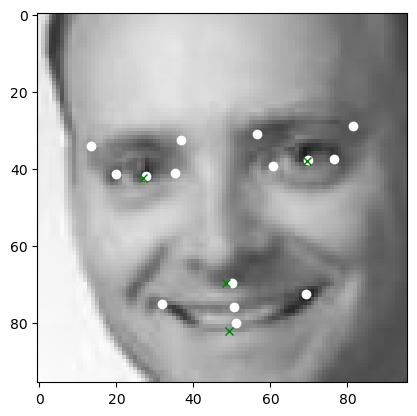

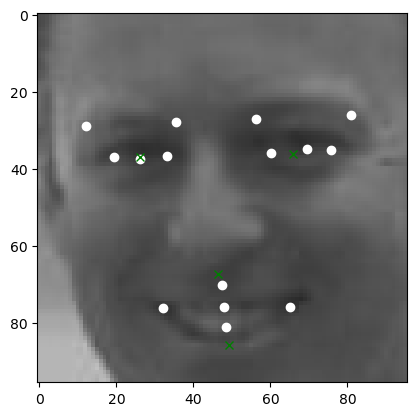

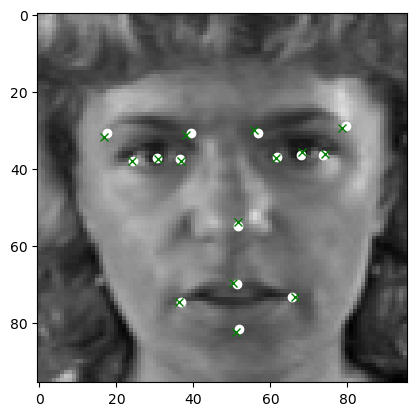

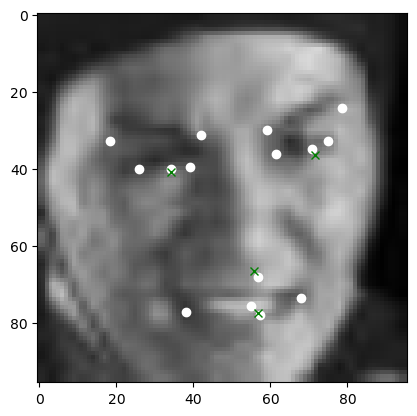

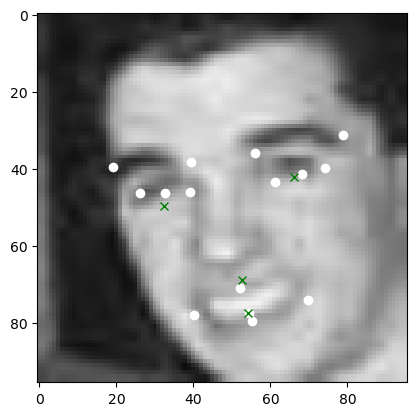

In [44]:
#Test demo for the model
IMAGES_TO_SHOW = 5
val_images_idxs = np.random.randint(0, len(val_set) - 1, 5)
transform = MyToTensor()
best_model.eval()
for idx in val_images_idxs:
    sample = val_set[idx]
    image = sample['image'].to(device)
    keypoints = sample['keypoints']
    with torch.no_grad():
        pred_keypoints = best_model(image.unsqueeze(0)).cpu().detach().numpy().reshape((30,))
    
    plt.imshow(image.cpu().detach().numpy().transpose((1, 2, 0)), cmap='gray')
    plt.plot(pred_keypoints[0::2], pred_keypoints[1::2], 'wo')
    plt.plot(keypoints[0::2], keypoints[1::2], 'gx')
    plt.show()

In [45]:
#Submission
id_lookup_data.head(3)

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN


In [46]:
test_data.head(3)

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...


In [47]:
sample_submission = pd.read_csv('./facial_keypoints/SampleSubmission.csv')
sample_submission.head()

,RowId,Location
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [48]:
print(len(id_lookup_data), len(sample_submission))

27124 27124


In [49]:
columns_keypoints = data.columns[:-1]
for column in columns_keypoints:
    test_data[str(column)] = 0.0
test_data.head()

,ImageId,Image,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,1,182 183 182 182 180 180 176 169 156 137 124 10...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,177 176 174 170 169 169 168 166 166 166 161 14...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,176 174 174 175 174 174 176 176 175 171 165 15...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
for i, column in enumerate(columns_keypoints):
    print(i, column)

0 left_eye_center_x
1 left_eye_center_y
2 right_eye_center_x
3 right_eye_center_y
4 left_eye_inner_corner_x
5 left_eye_inner_corner_y
6 left_eye_outer_corner_x
7 left_eye_outer_corner_y
8 right_eye_inner_corner_x
9 right_eye_inner_corner_y
10 right_eye_outer_corner_x
11 right_eye_outer_corner_y
12 left_eyebrow_inner_end_x
13 left_eyebrow_inner_end_y
14 left_eyebrow_outer_end_x
15 left_eyebrow_outer_end_y
16 right_eyebrow_inner_end_x
17 right_eyebrow_inner_end_y
18 right_eyebrow_outer_end_x
19 right_eyebrow_outer_end_y
20 nose_tip_x
21 nose_tip_y
22 mouth_left_corner_x
23 mouth_left_corner_y
24 mouth_right_corner_x
25 mouth_right_corner_y
26 mouth_center_top_lip_x
27 mouth_center_top_lip_y
28 mouth_center_bottom_lip_x
29 mouth_center_bottom_lip_y


In [51]:
test_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

best_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [52]:
for row_idx, test_row in test_data.iterrows():
    image = test_row['Image']
    image = np.fromstring(image, sep=' ').reshape([96, 96])
    image = np.stack((image, image, image), axis=-1)
    image = image / 255.0
    image = test_transform(image)
    image = image.unsqueeze(0)
    image = image.type(torch.FloatTensor)
    image = image.to(device)
    
    with torch.no_grad():
        pred_keypoints = best_model(image).cpu().detach().numpy().reshape((30,))
        
    for column_idx, column in enumerate(columns_keypoints):
        test_data.at[row_idx, column] = pred_keypoints[column_idx]
test_data.head()

,ImageId,Image,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,1,182 183 182 182 180 180 176 169 156 137 124 10...,66.302132,37.757607,29.316013,36.284603,60.369781,38.469238,72.649727,39.221279,...,49.926361,52.749557,63.177353,76.159706,32.399643,75.575249,48.438507,68.987541,48.144444,83.691574
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...,67.340965,36.534710,27.520281,37.266769,60.652084,37.196507,73.806732,36.798485,...,48.661827,59.894485,64.411926,75.435410,33.625767,76.439682,49.070358,72.828545,49.357971,86.707108
2,3,177 176 174 170 169 169 168 166 166 166 161 14...,66.206398,36.485394,31.161694,38.019604,60.447323,37.437943,72.060280,36.644131,...,49.360733,58.189754,63.516941,75.355568,36.370560,76.084534,49.753574,72.048416,49.479767,84.622917
3,4,176 174 174 175 174 174 176 176 175 171 165 15...,66.389130,39.113049,31.127562,40.490070,59.650143,39.905117,72.794273,39.998344,...,48.518749,54.959919,64.871666,77.109070,33.522423,78.113876,48.553226,71.591064,49.226501,80.964417
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...,66.533585,36.540161,28.138149,38.413540,60.519737,37.417225,73.160316,37.664684,...,47.498932,54.954659,64.459892,76.863968,34.238689,77.455704,48.244614,70.193245,48.730961,85.552094


In [53]:
sample_submission['Location'] = 0.0
for i, submission_row in sample_submission.iterrows():
    row_id = submission_row['RowId']
    feature_name = id_lookup_data[id_lookup_data['RowId'] == row_id]['FeatureName'].values[0]
    image_id = id_lookup_data[id_lookup_data['RowId'] == row_id]['ImageId'].values[0]
    sample_submission.at[i, 'Location'] = test_data[test_data['ImageId'] == image_id][feature_name]

In [54]:
sample_submission.to_csv('./submission.csv', index=False)